Example notebook to run gPhoton to create GALEX light curves etc.

In [1]:
%matplotlib widget
import gPhoton
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as uu
from astropy.io import ascii
from astropy.table import Table
import os

Do aperture photometry for each visit with gPhoton

In [5]:
%%time

# **** Setup analysis parameters *****

#Sources from ELAISN1_MOS15 in TDS, but not in VASCA
srcs = """recno	ID	ra	dec
71	ELAISN1_MOS15-20	242.8292	53.7492
184	ELAISN1_MOS15-24	243.0512	54.2599
307	ELAISN1_MOS15-03	242.1960	54.0721
390	ELAISN1_MOS15-22	242.8843	53.5921
417	ELAISN1_MOS15-18	242.7775	53.9643
441	ELAISN1_MOS15-13	242.4726	53.6579
495	ELAISN1_MOS15-00	241.6487	54.3255
873	ELAISN1_MOS15-14	242.6429	53.4919
934	ELAISN1_MOS15-12	242.4613	53.4860"""
tt_srcs = ascii.read(srcs)

src_idx = 0
outdir = "./TDS-ApJ_766_60/"
outfile = outdir+"gPhoton_"+str(tt_srcs[src_idx]["ID"])+'.npy'
ron = (10*uu.arcsec).to(uu.deg).value        # Radius of signal annulus
roff1 = (10*uu.arcsec).to(uu.deg).value      # Inner radius of background ring
roff2 = (20*uu.arcsec).to(uu.deg).value      # Outer radius of background ring

pos_ra = tt_srcs[src_idx]["ra"]
pos_dec = tt_srcs[src_idx]["dec"]

# **** Run analysis *****

#If pre-run file exist use it, run gPhoton analysis otherwise

if os.path.isfile(outfile):
    dd_gph = np.load(outfile,allow_pickle='TRUE').item()
else:
    print(f"Running query with gFind for:\n",tt_srcs[src_idx])
    dd_gfind = gPhoton.gFind(band='NUV',skypos=[pos_ra,pos_dec]) #,maxgap=100.,minexp=100.
    t_bins = list(zip(dd_gfind["NUV"]["t0"],dd_gfind["NUV"]["t1"]))

    print("Running lightcurve with gAperture..")
    dd_gaperture = gPhoton.gAperture(band='NUV',skypos=[pos_ra,pos_dec],radius=ron, annulus=[roff1,roff2],tranges=t_bins)
    dd_gph = {"gAperture":dd_gaperture,"gFind":dd_gfind}
    np.save(outfile,dd_gph)
    print("..done")

CPU times: user 2.35 ms, sys: 43.7 ms, total: 46.1 ms
Wall time: 183 ms


In [6]:
print(dd_gph["gAperture"].keys())
print("\n", dd_gph["gFind"]["NUV"].keys())
#print(dd_gph["gAperture"]['photons'])
keep_keys = ('t_mean', 'exptime','flux_bgsub', 'flux_bgsub_err','mag_bgsub', 'mag_bgsub_err_1', 'mag_bgsub_err_2',"flags")
dd_gap = {x: dd_gph["gAperture"][x] for x in keep_keys if x in dd_gph["gAperture"]}
tt_gap = Table(data= dd_gap)
tt_gap["s2n"]=dd_gap['flux_bgsub']/dd_gap['flux_bgsub_err']
sel_gap = tt_gap["s2n"]>3.5
display(tt_gap[sel_gap])

dict_keys(['params', 't0', 't1', 'exptime', 't0_data', 't1_data', 't_mean', 'q_mean', 'counts', 'flat_counts', 'responses', 'detxs', 'detys', 'detrad', 'racent', 'deccent', 'mcat_bg', 'bg_counts', 'bg_flat_counts', 'bg', 'cps', 'cps_err', 'cps_bgsub', 'cps_bgsub_err', 'cps_mcatbgsub', 'cps_mcatbgsub_err', 'flux', 'flux_err', 'flux_bgsub', 'flux_bgsub_err', 'flux_mcatbgsub', 'flux_mcatbgsub_err', 'mag', 'mag_err_1', 'mag_err_2', 'mag_bgsub', 'mag_bgsub_err_1', 'mag_bgsub_err_2', 'mag_mcatbgsub', 'mag_mcatbgsub_err_1', 'mag_mcatbgsub_err_2', 'photons', 'flags'])

 dict_keys(['expt', 't0', 't1', 'nearest_source'])


t_mean,exptime,flux_bgsub,flux_bgsub_err,mag_bgsub,mag_bgsub_err_1,mag_bgsub_err_2,flags,s2n
float64,float64,float64,float64,float64,float64,float64,float64,float64
802267923.1495593,1014.5231948290783,1.7804307836427198e-17,5.0657652348447764e-18,22.73835531435877,0.27185614395139623,0.3635133769849723,0.0,3.5146334287188403
802374589.1704702,734.4640726768934,2.0586436123474383e-17,5.6918150807960464e-18,22.58071512826742,0.26503822712795966,0.3513792773372728,0.0,3.6168490773588524
929622856.1948605,1328.7775590872222,1.6944597116512677e-17,4.000550669890856e-18,22.792089932706926,0.23013045437616242,0.29240296163319357,0.0,4.235566179436733
987629636.2642901,1276.2881343580063,4.8966987203231154e-17,5.423520237386851e-18,21.63990959102351,0.11404931664914031,0.12745094750555808,0.0,9.028635472894322
989054810.7792666,1166.4554074674954,1.6718535217083914e-17,4.4307296598126346e-18,22.806672490026127,0.2552426301473467,0.33430973477554815,0.0,3.773314217006619


Display lightcurve

<ErrorbarContainer object of 3 artists>

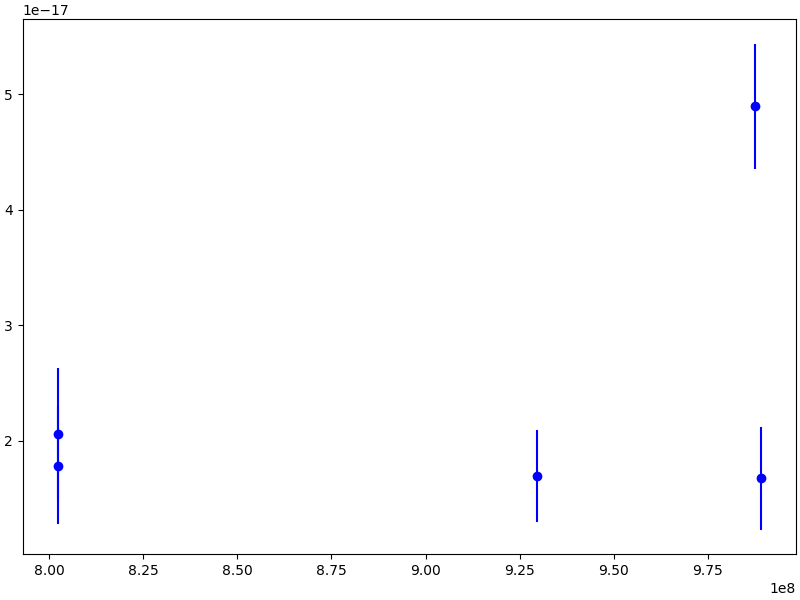

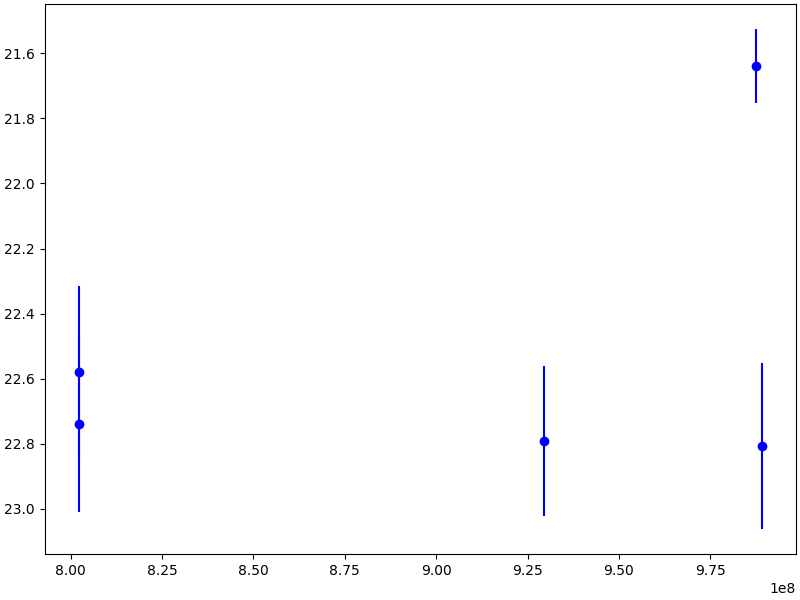

In [7]:
fig = plt.figure(figsize=(8, 6), constrained_layout=True)
plt.errorbar(tt_gap[sel_gap]['t_mean'],tt_gap[sel_gap]['flux_bgsub'],yerr=tt_gap[sel_gap]['flux_bgsub_err'],fmt="bo")

fig2 = plt.figure(figsize=(8, 6), constrained_layout=True)
ax = plt.gca()
ax.invert_yaxis()
plt.errorbar(tt_gap[sel_gap]['t_mean'],tt_gap[sel_gap]['mag_bgsub'],yerr=tt_gap[sel_gap]['mag_bgsub_err_1'],fmt="bo")